<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/EfficientNet_b4_ImageNet_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravCont: EfficientNet_b4_ImageNet**

In [1]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 51kB 2.6MB/s 
Random Seed:  1234
Mounted at /content/drive


#**Convnetの調整**

In [3]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b4')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
optimizer_ft = optim.AdaBound(
    model_ft.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=f5b973dee0033eedcfbf34a05b8b1263a3ec1267f2ee4b7b7d59d4b71ab3be2a
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


#**ネットワークの読み込み**

In [4]:
#ネットワークの読み込み
PATH = '/content/drive/My Drive/EfficientNet_ImageNet_558_1.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#**Calculate Accuracy**
・True positive (TN)<br>
・False positive (FP)<br>
・True negative (TN)<br>
・False negative (FN)<br>

Accuracy = (TP + TN)/ (TP + TN + FP + FN)<br>
Precision = TP/(FP + TP) ※positive predictive value<br>
Recall = TP/(TP + FN)　※sensitivity<br>
Specificity = TN/(FP + TN)<br>
F_value = (2RecallPrecision)/(Recall+Precision)<br>

In [7]:
data_dir = "/content/drive/My Drive/Grav_bootcamp/Posttrain_250px"

#評価モードにする
model_ft.eval()

#valフォルダ内のファイル名を取得
image_path = glob.glob(data_dir + "/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 


#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label, class_names):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred

    """
    #probalilityを計算する
    pred_prob = torch.topk(nn.Softmax(dim=1)(output), 1)[0]
    pred_class = torch.topk(nn.Softmax(dim=1)(output), 1)[1]
    if pred_class == 1:
        pred_prob = pred_prob
    elif pred_class == 0:
        pred_prob = 1- pred_prob
    return(model_pred, pred_prob)  #class_nameの番号で出力される
    """

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)


#ここからがメイン
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []

class_names = ["cont", "grav"]


for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label, class_names)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TN += 1
          else:
              FP += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TP += 1
          else:
              FN += 1
      

print(TP, FN, TN, FP)

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

print(model_pred_class)
print(model_pred_prob)

number of images: 108
43 11 50 4
Accuracy: 0.8611111111111112
Precision (positive predictive value): 0.9148936170212766
Recall (sensitivity): 0.7962962962962963
Specificity: 0.9259259259259259
F_value: 0.8514851485148516
[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
[0.004621386528015137, 8.106231689453125e-06, 0.9999299049377441, 0.008290469646453857, 0.0002606511116027832, 0.6723669171333313, 5.125999450683594e-06, 0.9897716641426086, 0.0034349560737609863, 0.9990155696868896, 0.18292951583862305, 0.39623987674713135, 0.9999806880950928, 0.001571357250213623, 0.0960463285446167, 0.34883129596710205, 0.00022858381271362305, 0.2336013913154602, 0.9348597526550293, 0.8562542200088501, 3.790855407714844e-05, 0.005

#**Drawing ROC curve**

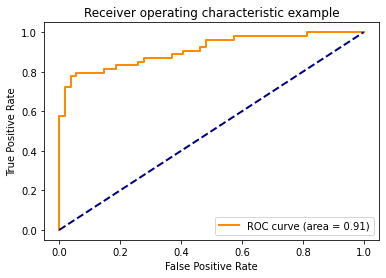

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true
#それぞれの画像における陽性の確率についてリストを作成
y_score = model_pred_prob

#print(y_true)
#print(y_score)

fpr, tpr,thred = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

#print(fpr)
#print(tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


#**ネットワークの保存と読み込み**

In [ ]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/GravCont_EfficientNet-b4_ImageNet_seed'+str(manualSeed)+'.pth'
torch.save(model_ft.state_dict(), PATH)